<a href="https://colab.research.google.com/github/p0xwave/HSE-ML-Course/blob/main/notebooks/AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [61]:
!pip install catboost category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 5.3 MB/s eta 0:00:00


In [137]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

In [2]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [3]:
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [9]:
allowed_values = {
    'experience_level': {'SE', 'MI', 'EN', 'EX'},
    'employment_type': {'FT', 'PT', 'CT', 'FL'},
    'company_size': {'S', 'M', 'L'},
    'remote_ratio': {0, 50, 100}
}

In [10]:
for col, allowed in allowed_values.items():
    if df[col].isnull().any():
        print(f"Столбец '{col}' содержит пропуски (NaN)")

    if all(isinstance(x, str) for x in allowed):
        cleaned = df[col].astype(str).str.strip().str.upper()
        unique_vals = set(cleaned.dropna().unique())
    else:
        unique_vals = set(df[col].dropna().unique())

    invalid = unique_vals - allowed
    if invalid:
        print(f"Столбец '{col}' содержит недопустимые значения: {invalid}")
    else:
        print(f"Столбец '{col}' корректен (все значения допустимы)")

Столбец 'experience_level' корректен (все значения допустимы)
Столбец 'employment_type' корректен (все значения допустимы)
Столбец 'company_size' корректен (все значения допустимы)
Столбец 'remote_ratio' корректен (все значения допустимы)


## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [19]:
df.head(1)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L


In [14]:
df.isnull().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


In [15]:
df.dtypes

,0
work_year,int64
experience_level,object
employment_type,object
job_title,object
salary,int64
salary_currency,object
salary_in_usd,int64
employee_residence,object
remote_ratio,int64
company_location,object


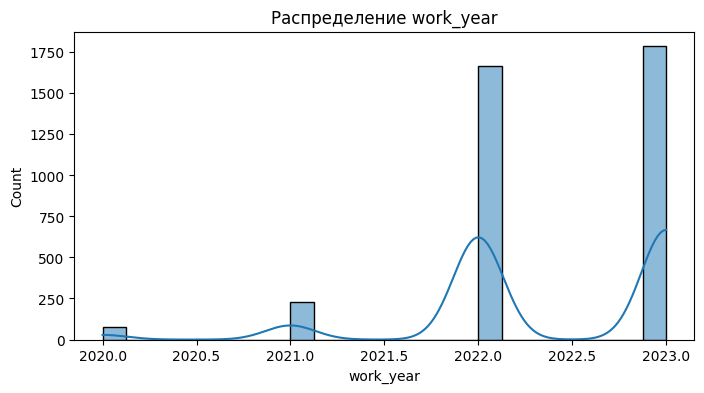

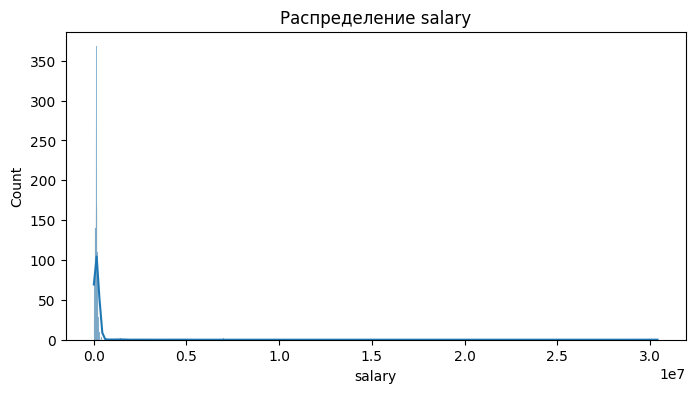

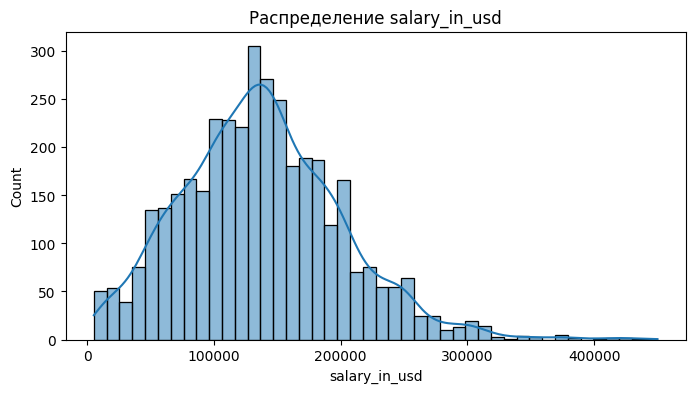

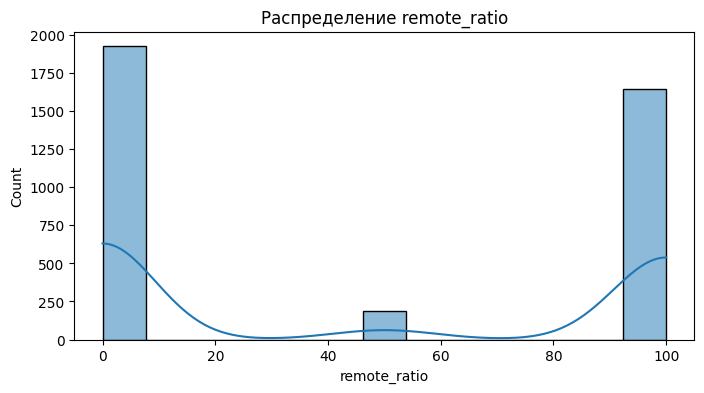

In [22]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Распределение {col}')
    plt.show()

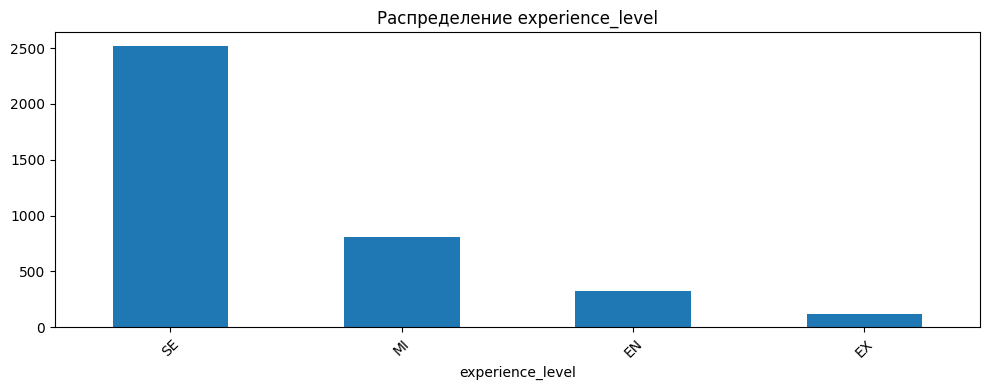

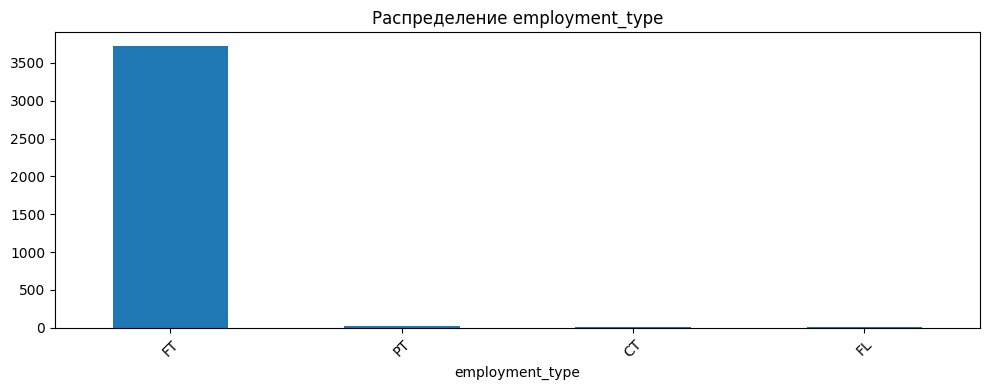

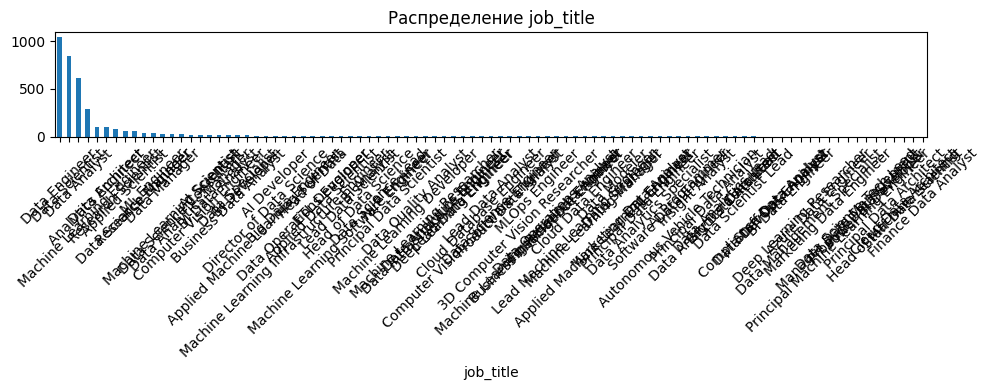

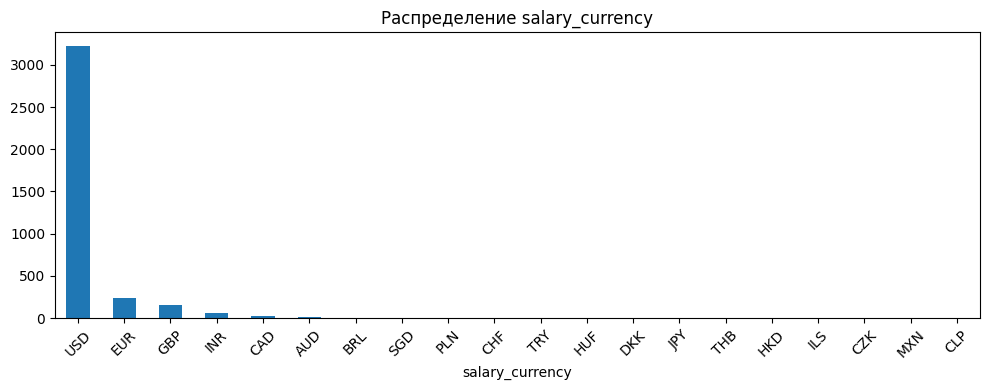

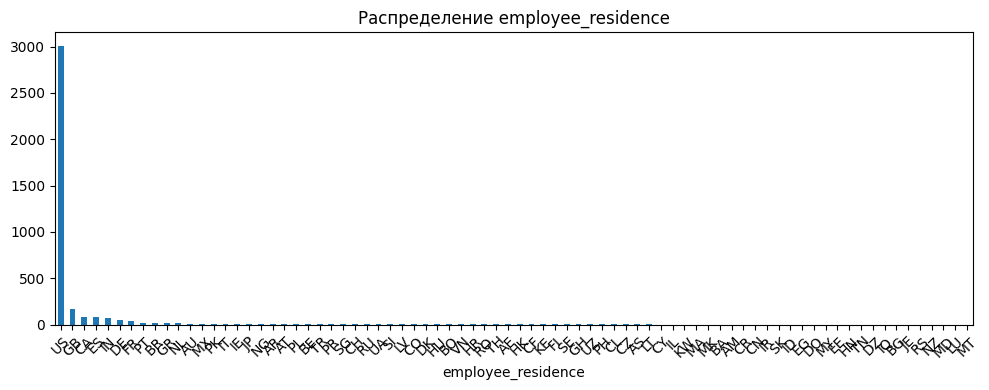

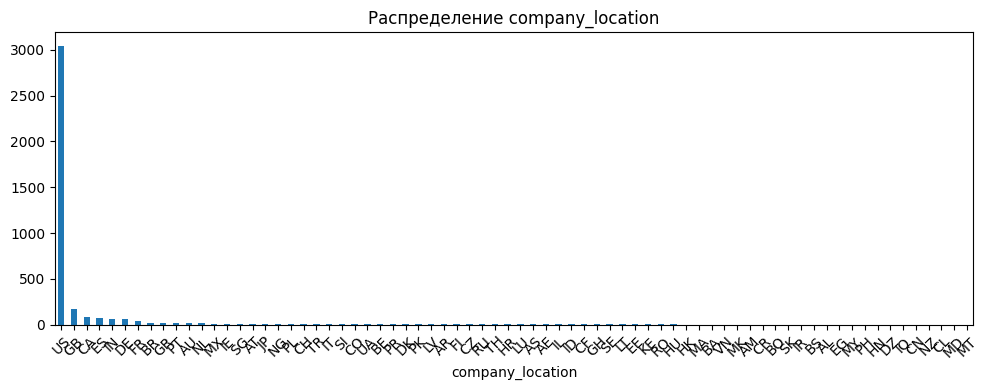

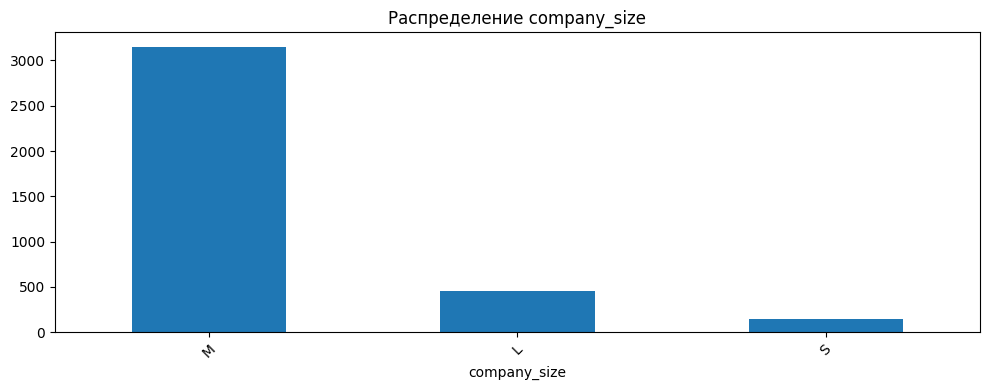

In [23]:
for col in cat_cols:
    plt.figure(figsize=(10,4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Распределение {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [25]:
df[num_cols].describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [27]:
df[cat_cols].describe()

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,3755,3755,3755,3755,3755,3755,3755
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,2516,3718,1040,3224,3004,3040,3153


Пропусков нет. Типы данных все соответствуют колонкам. Допустимые значения проверили выше

Видим некоторые проблемы с распределением salary например, так как там абсолютно разные валюты. Учтём это дальше
Также с распложением работника очень много значений и с расположением компании. Надо будет это правильно кормить в модель

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

In [28]:
# Целевая переменная: salary_in_usd. Признак salary напрямую связан с целевой (конвертированное значение),
# что приведет к утечке данных да и границы у него слишком большие из-за разных валют. Удаляем его и salary_currency
df = df.drop(columns=['salary', 'salary_currency'])

Много категорий из прошлого задания видно в job_title, employee_residence, company_location

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [31]:
X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [33]:
cont_features = ['work_year', 'remote_ratio']
X_train_cont = X_train[cont_features]
X_test_cont = X_test[cont_features]

X_train_all = X_train.copy()
X_test_all = X_test.copy()

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [39]:
model = LinearRegression()
model.fit(X_train_cont, y_train)
y_pred = model.predict(X_test_cont)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}')

RMSE: 61358.94
MAPE: 0.71


Модель супер плохо предсказывает цену, но это и логично, так как на признаке год и процент удаленки невозможно предсказать зарплату. Это почти что игра в угадайку

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [43]:
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(X_train_cont, y_train)
y_pred = model.predict(X_test_cont)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}')

RMSE: 61477.30
MAPE: 0.69


Впринципе RMSE +- такой же как и у линейной регрессии, но MAPE чуть упал, хоть и немного

Вывод: Сильного улучшения изменение модели не дало

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попробуем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [77]:
cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = ['work_year', 'remote_ratio']

results = []

### one hot encoder

In [51]:
preprocessor = ColumnTransformer([
    ('num', 'passthrough', num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
])
preprocessor.fit(X_train)
X_train_enc = preprocessor.transform(X_train)
X_test_enc = preprocessor.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_enc, y_train)
y_pred_lr = lr.predict(X_test_enc)
rmse_ohe_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mape_ohe_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

cb = CatBoostRegressor(verbose=0, random_state=42)
cb.fit(X_train_enc, y_train)
y_pred_cb = cb.predict(X_test_enc)
rmse_ohe_cb = np.sqrt(mean_squared_error(y_test, y_pred_cb))
mape_ohe_cb = mean_absolute_percentage_error(y_test, y_pred_cb)

In [78]:
results.extend(
    [
        {"method": "ohe", "model": "lr", "rmse": rmse_ohe_lr, "mape": mape_ohe_lr},
        {"method": "ohe", "model": "cb", "rmse": rmse_ohe_cb, "mape": mape_ohe_cb},
    ]
)

### label encoding

In [55]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

for col in cat_features:
    le = LabelEncoder()
    X_train_le[col] = le.fit_transform(X_train_le[col])

    # Для test обрабатываем неизвестные категории
    # Заменяем неизвестные на самую частую категорию из train
    X_test_le[col] = X_test_le[col].apply(
        lambda x: x if x in le.classes_ else le.classes_[0]
    )
    X_test_le[col] = le.transform(X_test_le[col])

In [56]:
lr = LinearRegression()
lr.fit(X_train_le, y_train)
y_pred_lr = lr.predict(X_test_le)
rmse_le_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mape_le_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

cb = CatBoostRegressor(verbose=0, random_state=42)
cb.fit(X_train_le, y_train)
y_pred_cb = cb.predict(X_test_le)
rmse_le_cb = np.sqrt(mean_squared_error(y_test, y_pred_cb))
mape_le_cb = mean_absolute_percentage_error(y_test, y_pred_cb)

In [79]:
results.extend(
    [
        {"method": "label enc", "model": "lr", "rmse": rmse_le_lr, "mape": mape_le_lr},
        {"method": "label enc", "model": "cb", "rmse": rmse_le_cb, "mape": mape_le_cb},
    ]
)

### target enc

In [64]:
te = TargetEncoder(cols=cat_features)
X_train_te = te.fit_transform(X_train, y_train)
X_test_te = te.transform(X_test)

In [65]:
lr = LinearRegression()
lr.fit(X_train_te, y_train)
y_pred_lr = lr.predict(X_test_te)
rmse_te_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mape_te_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

cb = CatBoostRegressor(verbose=0, random_state=42)
cb.fit(X_train_te, y_train)
y_pred_cb = cb.predict(X_test_te)
rmse_te_cb = np.sqrt(mean_squared_error(y_test, y_pred_cb))
mape_te_cb = mean_absolute_percentage_error(y_test, y_pred_cb)

In [80]:
results.extend(
    [
        {"method": "target enc", "model": "lr", "rmse": rmse_te_lr, "mape": mape_te_lr},
        {"method": "target enc", "model": "cb", "rmse": rmse_te_cb, "mape": mape_te_cb},
    ]
)

### Выводы и сравнение

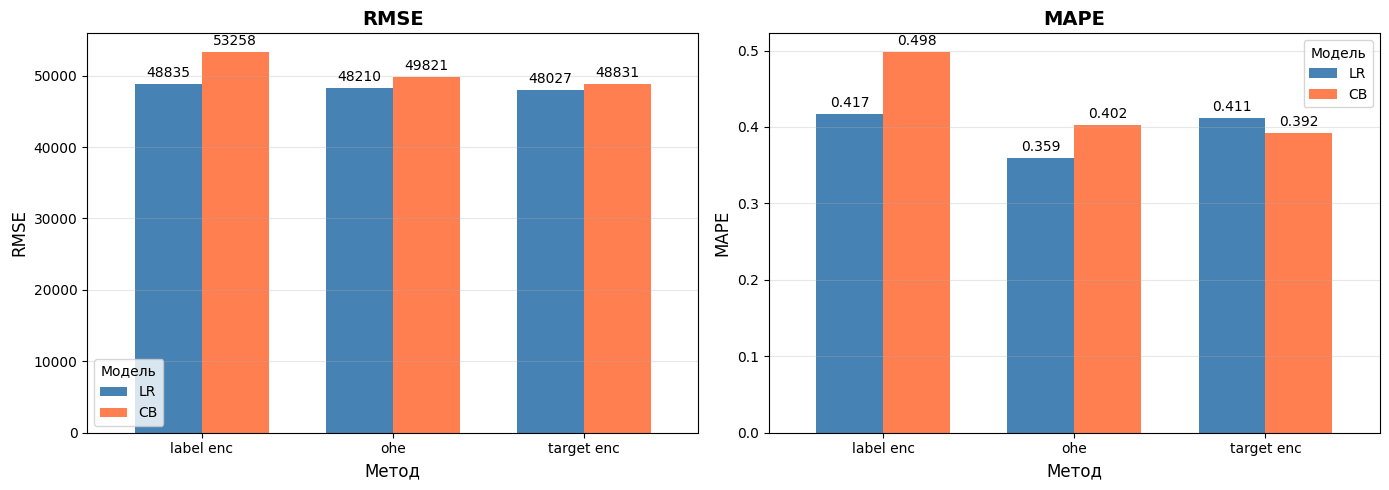

In [83]:
df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df_pivot_rmse = df.pivot(index='method', columns='model', values='rmse')
df_pivot_rmse.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'], width=0.7)
axes[0].set_title('RMSE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Метод', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].legend(title='Модель', labels=['LR', 'CB'])
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.0f', padding=3)

df_pivot_mape = df.pivot(index='method', columns='model', values='mape')
df_pivot_mape.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'], width=0.7)
axes[1].set_title('MAPE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Метод', fontsize=12)
axes[1].set_ylabel('MAPE', fontsize=12)
axes[1].legend(title='Модель', labels=['LR', 'CB'])
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

Лучшая связка явно OHE + CatBoost по MAPE и почти идельна по RMSE, разница с соседом совсем не большая, поэтому дальше будем работать с ней

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [85]:
# обучу модель ещё раз чтобы работать с ней дальше

preprocessor = ColumnTransformer([
    ('num', 'passthrough', num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
])
preprocessor.fit(X_train)
X_train_enc = preprocessor.transform(X_train)
X_test_enc = preprocessor.transform(X_test)

cb = CatBoostRegressor(verbose=0, random_state=42)
cb.fit(X_train_enc, y_train)
y_pred_cb = cb.predict(X_test_enc)
rmse_ohe_cb = np.sqrt(mean_squared_error(y_test, y_pred_cb))
mape_ohe_cb = mean_absolute_percentage_error(y_test, y_pred_cb)

In [87]:
errors = np.abs(y_test.values - y_pred_cb)
test_with_errors = X_test.copy()
test_with_errors['actual'] = y_test.values
test_with_errors['predicted'] = y_pred_cb
test_with_errors['abs_error'] = errors

top_errors = test_with_errors.nlargest(20, 'abs_error')
top_errors

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,actual,predicted,abs_error
1288,2023,SE,FT,Data Analyst,US,0,US,M,385000,130642.084388,254357.915612
2359,2022,SE,FT,Data Science Tech Lead,US,50,US,L,375000,162532.969602,212467.030398
1105,2023,SE,FT,Data Scientist,US,0,US,M,370000,168193.966631,201806.033369
218,2023,SE,FT,Applied Data Scientist,AU,100,FI,M,68318,231316.957077,162998.957077
478,2023,EX,FT,Director of Data Science,US,0,US,M,353200,193307.595069,159892.404931
3609,2020,SE,FT,Machine Learning Scientist,JP,0,JP,S,260000,102256.088661,157743.911339
1116,2023,SE,FT,Machine Learning Engineer,US,0,US,M,323300,175126.448911,148173.551089
1593,2023,SE,FT,Data Engineer,US,0,US,M,300000,158630.896664,141369.103336
33,2023,SE,FT,Computer Vision Engineer,US,0,US,M,342810,202847.005141,139962.994859
2009,2022,SE,FT,Machine Learning Engineer,MX,100,MX,M,255000,116580.613637,138419.386363


Модель чаще всего ошибается на зарплатах выше 300к, причём как в сторону недооценки, так и переоценки.

Многие ошибки связаны с должностями уровня Senior и Executive, что ожидаемо, так как это редкие и высокооплачиваемые позиции.

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [128]:
X_train_new = X_train.copy()
X_test_new = X_test.copy()

# Регион по стране
all_countries = pd.concat([X_train['employee_residence'], X_train['company_location'],
                           X_test['employee_residence'], X_test['company_location']]).unique()
region_map = {}
for country in all_countries:
    if country == 'US':
        region_map[country] = 'US'
    elif country in ['CA', 'MX', 'BR', 'AR', 'CL']:
        region_map[country] = 'AMERICAS'
    elif country in ['GB', 'DE', 'FR', 'ES', 'IT', 'NL', 'CH', 'SE', 'DK', 'FI', 'NO', 'PL', 'PT', 'BE', 'AT', 'IE', 'GR', 'CZ', 'HU', 'RO', 'BG', 'HR', 'LT', 'LV', 'EE', 'SK', 'SI', 'CY', 'LU', 'MT']:
        region_map[country] = 'EUROPE'
    elif country in ['IN', 'CN', 'JP', 'KR', 'SG', 'MY', 'TH', 'VN', 'ID', 'PH', 'PK', 'BD', 'LK', 'NP']:
        region_map[country] = 'ASIA'
    elif country in ['AU', 'NZ']:
        region_map[country] = 'OCEANIA'
    elif country in ['ZA', 'NG', 'KE', 'EG', 'MA', 'TN']:
        region_map[country] = 'AFRICA'
    else:
        region_map[country] = 'OTHER'

X_train_new['emp_region'] = X_train_new['employee_residence'].map(region_map)
X_test_new['emp_region'] = X_test_new['employee_residence'].map(region_map)
X_train_new['comp_region'] = X_train_new['company_location'].map(region_map)
X_test_new['comp_region'] = X_test_new['company_location'].map(region_map)

In [129]:
# same_country: совпадает ли страна проживания с локацией компании
X_train_new['same_country'] = (X_train_new['employee_residence'] == X_train_new['company_location']).astype(int)
X_test_new['same_country'] = (X_test_new['employee_residence'] == X_test_new['company_location']).astype(int)

In [130]:
# Числовой код размера компании
size_map = {'S': 0, 'M': 1, 'L': 2}
X_train_new['company_size'] = X_train_new['company_size'].map(size_map)
X_test_new['company_size'] = X_test_new['company_size'].map(size_map)

In [131]:
X_train_new

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,emp_region,comp_region,same_country
2238,2022,SE,FT,Data Engineer,ES,0,ES,1,EUROPE,EUROPE,1
485,2023,MI,FT,Research Scientist,US,100,US,1,US,US,1
2177,2022,SE,FT,Data Analyst,US,0,US,1,US,US,1
3305,2022,SE,FT,Data Engineer,US,100,US,1,US,US,1
1769,2023,SE,FT,Data Engineer,US,100,US,1,US,US,1
...,...,...,...,...,...,...,...,...,...,...,...
1130,2023,SE,FT,Machine Learning Engineer,US,100,US,1,US,US,1
1294,2023,SE,FT,Data Analyst,US,0,US,1,US,US,1
860,2023,EX,FT,Data Engineer,US,100,US,1,US,US,1
3507,2021,MI,FT,Research Scientist,FR,50,FR,1,EUROPE,EUROPE,1


In [132]:
# Взаимодействие remote_ratio с опытом (числовой код опыта)
exp_map = {'EN': 0, 'MI': 1, 'SE': 2, 'EX': 3}
X_train_new['experience_level'] = X_train_new['experience_level'].map(exp_map)
X_test_new['experience_level'] = X_test_new['experience_level'].map(exp_map)

X_train_new['remote_exp'] = X_train_new['remote_ratio'] * X_train_new['experience_level']
X_test_new['remote_exp'] = X_test_new['remote_ratio'] * X_test_new['experience_level']

In [133]:
# employment_type тоже цифрами
exp_map = {'FT': 0, 'PT': 1, 'CT': 2, 'FL': 3}
X_train_new['employment_type'] = X_train_new['employment_type'].map(exp_map)
X_test_new['employment_type'] = X_test_new['employment_type'].map(exp_map)

In [134]:
X_train_new

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,emp_region,comp_region,same_country,remote_exp
2238,2022,2,0,Data Engineer,ES,0,ES,1,EUROPE,EUROPE,1,0
485,2023,1,0,Research Scientist,US,100,US,1,US,US,1,100
2177,2022,2,0,Data Analyst,US,0,US,1,US,US,1,0
3305,2022,2,0,Data Engineer,US,100,US,1,US,US,1,200
1769,2023,2,0,Data Engineer,US,100,US,1,US,US,1,200
...,...,...,...,...,...,...,...,...,...,...,...,...
1130,2023,2,0,Machine Learning Engineer,US,100,US,1,US,US,1,200
1294,2023,2,0,Data Analyst,US,0,US,1,US,US,1,0
860,2023,3,0,Data Engineer,US,100,US,1,US,US,1,300
3507,2021,1,0,Research Scientist,FR,50,FR,1,EUROPE,EUROPE,1,50


In [135]:
preprocessor = ColumnTransformer([
    ('num', 'passthrough', num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ["job_title", "employee_residence", "emp_region", "comp_region"])
])
preprocessor.fit(X_train_new)
X_train_enc = preprocessor.transform(X_train_new)
X_test_enc = preprocessor.transform(X_test_new)

cb = CatBoostRegressor(verbose=0, random_state=42)
cb.fit(X_train_enc, y_train)
y_pred_cb = cb.predict(X_test_enc)
rmse_ohe_cb = np.sqrt(mean_squared_error(y_test, y_pred_cb))
mape_ohe_cb = mean_absolute_percentage_error(y_test, y_pred_cb)

In [136]:
rmse_ohe_cb, mape_ohe_cb

(np.float64(50213.18753659165), 0.3885757920687113)

Попробовал сделать обобщающий признак по странам и поменьше one hot encodить на те признаки, которые можно сделать просто цифрами от 0 до 5.
Мапе уменьшилось, но rmse подросло. Думаю это можно считать успехом так как RMSE всё равно огромная скорее всего из-за огромных выбросов зарплат :D

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [141]:
def calculate_metrics(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_percentage_error(y_test, y_pred)

In [143]:
start_time = time.time()

cb_base = CatBoostRegressor(
    random_state=42,
    verbose=0
)

cb_base.fit(
    X_train_enc,
    y_train,
)

train_time_base = time.time() - start_time

start_time = time.time()
y_pred_base = cb_base.predict(X_test_enc)
predict_time_base = time.time() - start_time

mape_base, rmse_base = calculate_metrics(y_test, y_pred_base)

print(f"Время обучения: {train_time_base} сек")
print(f"Время предсказания: {predict_time_base} сек")

Время обучения: 2.2644224166870117 сек
Время предсказания: 0.0920555591583252 сек


In [144]:
mape_base, rmse_base

(np.float64(50213.18753659165), 0.3885757920687113)

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [2, 4, 6],
    'iterations': [100, 200, 300, 500, 1000],
    'l2_leaf_reg': [1, 3, 5, 10],

}

start_time = time.time()

cb_grid = CatBoostRegressor(
    random_state=42,
    verbose=0
)

grid_search = GridSearchCV(
    estimator=cb_grid,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_percentage_error',  # Минимизируем MAPE
    n_jobs=-1,
    verbose=1
)

grid_search.fit(
    X_train_enc,
    y_train,
)

grid_search_time = time.time() - start_time

print(f"\nВремя подбора параметров: {grid_search_time} сек")
print(f"\nЛучшие параметры:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\nЛучший score: {grid_search.best_score_}")


Fitting 3 folds for each of 180 candidates, totalling 540 fits


In [ ]:
start_time = time.time()

cb_best = grid_search.best_estimator_

train_time_best = time.time() - start_time

start_time = time.time()
y_pred_best = cb_best.predict(X_test_enc)
predict_time_best = time.time() - start_time

mape_best, rmse_best = calculate_metrics(y_test, y_pred_best)

print(f"\nВремя обучения: {train_time_best} сек")
print(f"Время предсказания: {predict_time_best} сек")

pd.DataFrame({
    'Модель': ['Базовая', 'Оптимизированная'],
    'MAPE (%)': [mape_base, mape_best],
    'RMSE ($)': [rmse_base, rmse_best],
    'Время обучения (сек)': [train_time_base, train_time_best],
    'Время предсказания (сек)': [predict_time_base, predict_time_best]
})

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
# Ваш код здесь
X =
y =

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
# Ваш код здесь
scaler =
X_scaled =

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
# Ваш код здесь
pca =
X_pca =

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

In [ ]:
# Ваш код здесь
plt.scatter()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
# Ваш код здесь

### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

In [ ]:
# Ваш код здесь

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш вывод здесь**

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный кот :)

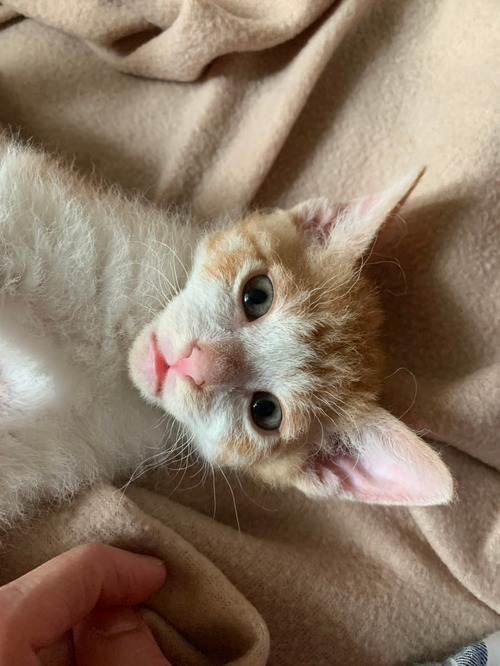